In [1]:
%matplotlib inline

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

def a3(wd_coefficient, n_hid, n_iters, learning_rate,
        momentum_multiplier, do_early_stopping, mini_batch_size):

    model = initial_model(n_hid)

    # Load data
    from_data_file = sio.loadmat('data.mat')['data']
    training_data = {}
    training_data['inputs'] = from_data_file[0][0]['training'][0][0]['inputs']
    training_data['targets'] = from_data_file[0][0]['training'][0][0]['targets']
    validation_data = {}
    validation_data['inputs'] = from_data_file[0][0]['validation'][0][0]['inputs']
    validation_data['targets'] = from_data_file[0][0]['validation'][0][0]['targets']
    test_data = {}
    test_data['inputs'] = from_data_file[0][0]['test'][0][0]['inputs']
    test_data['targets'] = from_data_file[0][0]['test'][0][0]['targets']

    n_training_cases = training_data['inputs'].shape[1]
#     if n_iters != 0:
#         test_gradient(model, training_data, wd_coefficient)

    # Optimization
    theta = model_to_theta(model)
    momentum_speed = theta * 0
    training_data_losses = []
    validation_data_losses = []
    best_so_far = {}
    if do_early_stopping:
        best_so_far['theta'] = -1 # this will be overwritten soon
        best_so_far['validation_loss'] = np.inf
        best_so_far['after_n_iters'] = -1

    for optimization_iteration_i in range(1,n_iters+1):
        #print('optimization_iteration_i',optimization_iteration_i)
        model = theta_to_model(theta)
        training_batch = {}
        training_batch_start = ((optimization_iteration_i-1) * mini_batch_size)\
                               % n_training_cases + 1
        training_batch['inputs'] = training_data['inputs'][:,
            training_batch_start-1 : training_batch_start-1 + mini_batch_size ]
        training_batch['targets'] = training_data['targets'][:,
            training_batch_start-1 : training_batch_start-1 + mini_batch_size ]
        gradient = model_to_theta(d_loss_by_d_model(model,
                    training_batch, wd_coefficient))
        momentum_speed = momentum_speed * momentum_multiplier - gradient
        theta = theta + momentum_speed * learning_rate

        model = theta_to_model(theta)
        training_data_losses.append(loss(model, training_data, wd_coefficient))
        validation_data_losses.append(loss(model, validation_data, wd_coefficient))

        if do_early_stopping and \
            validation_data_losses[-1] < best_so_far['validation_loss']:
          best_so_far['theta'] = theta # this will be overwritten soon
          best_so_far['validation_loss'] = validation_data_losses[-1]
          best_so_far['after_n_iters'] = optimization_iteration_i

#         if optimization_iteration_i % round(n_iters/10) == 0:
#             print('After ', optimization_iteration_i, 'optimization iterations,'
#                 ' training data loss is', training_data_losses[-1],
#                 ', and validation data loss is ', validation_data_losses[-1])
    
#     if n_iters != 0:
#         # check again, this time with more typical parameters
#         test_gradient(model, training_data, wd_coefficient)

    if do_early_stopping:
        print('Early stopping: validation loss was lowest after ',
            best_so_far['after_n_iters'],  'iterations. We chose the '
            'model that we had then.')
        theta = best_so_far['theta']


    # The optimization is finished. Now do some reporting.
    model = theta_to_model(theta)

    if n_iters != 0:
        plt.figure(1)
        plt.clf()
        plt.plot(range(n_iters),training_data_losses, 'b')
        plt.plot(range(n_iters),validation_data_losses, 'r')
        plt.legend(['training', 'validation'])
        plt.ylabel('loss')
        plt.xlabel('iteration number')
        plt.show()

    datas2 = [training_data, validation_data, test_data]
    data_names = ['training', 'validation', 'test']
    for data_i in range (0,3):
        data = datas2[data_i]
        data_name = data_names[data_i]
        print('The loss on the ', data_name, "data is ",
              loss(model, data, wd_coefficient))
        if wd_coefficient != 0:
            print('The classification loss (i.e. without weight decay) on the ',
                data_name, "data is ", loss(model, data, 0))
        print('The classification error rate on the', data_name, 'data is ',
            classification_performance(model, data))
    print('end')
def test_gradient(model, data, wd_coefficient):
    base_theta = model_to_theta(model)
    h = 0.01
    correctness_threshold = 0.00001
    analytic_gradient = model_to_theta(
                d_loss_by_d_model(model, data, wd_coefficient))
    # Test the gradient not for every element of theta, because that's
    # a lot of work. Test for only a few elements.
    for i in range(1,101):

        # 1299721 is prime and thus ensures a somewhat random-like
        # selection of indices
        test_index = (i * 1299721) % base_theta.shape[0]

        analytic_here = analytic_gradient[test_index]
        theta_step = base_theta * 0
        theta_step[test_index] = h
        contribution_distances = [-4, -3, -2, -1, 1, 2, 3, 4]
        contribution_weights = [1/280, -4/105, 1/5, -4/5, 4/5, -1/5, 4/105, -1/280]
        temp = 0
        for contribution_index in range(8):
            temp = temp + loss(theta_to_model(
                    base_theta +
                    theta_step * contribution_distances[contribution_index]),
                data,
                wd_coefficient) * contribution_weights[contribution_index]

        fd_here = temp / h
        diff = np.abs(analytic_here - fd_here)
        if diff < correctness_threshold:
            continue
        if diff / (np.abs(analytic_here) + np.abs(fd_here)) < \
                        correctness_threshold:
            continue

#         print('Error! Theta element #', test_index+1 , ', with value ',
#             base_theta[test_index], 'has finite difference gradient', fd_here,
#             'but analytic gradient is', analytic_here,'That looks like an error.')
        quit()

    print('Gradient test passed. That means that the gradient that your '
          'code computed is within 0.001% of the gradient that the finite'
          ' difference approximation computed, so the gradient calculation'
          ' procedure is probably correct (not certainly, but probably).')
def logistic(input):
    return 1 / (1 + np.exp(-input))

def log_sum_exp_over_rows(a):
    # This computes log(sum(exp(a), axis=0)) in a numerically stable way
    maxs_small = np.reshape(np.amax(a, axis=0),(1,-1), order="F")
    maxs_big = np.tile(maxs_small, (a.shape[0], 1))
    ret = np.log(np.sum(np.exp(a - maxs_big), axis=0)) + maxs_small
    return ret

def loss(model, data, wd_coefficient):
    # model['input_to_hid'] is a matrix of size <number of hidden units> by
    # <number of inputs i.e. 256>. It contains the weights from the input
    # units to the hidden units.
    # model['hid_to_class'] is a matrix of size <number of classes i.e. 10>
    # by <number of hidden units>. It contains the weights from the hidden
    # units to the softmax units.
    # data['inputs'] is a matrix of size <number of inputs i.e. 256> by
    # <number of data cases>. Each column describes a different data case.
    # data['targets'] is a matrix of size <number of classes i.e. 10> by
    # <number of data cases>. Each column describes a different data case.
    # It contains a one-of-N encoding of the class, i.e. one element in
    # every column is 1 and the others are 0.

    # Before we can calculate the loss, we need to calculate a variety
    # of intermediate values, like the state of the hidden units.

    # input to the hidden units, i.e. before the logistic.
    # size: <number of hidden units> by <number of data cases>
    hid_input = np.dot(model['input_to_hid'], data['inputs'])

    # output of the hidden units, i.e. after the logistic.
    # size: <number of hidden units> by <number of data cases>
    hid_output = logistic(hid_input)

    # input to the components of the softmax.
    # size: <number of classes, i.e. 10> by <number of data cases>
    class_input = np.dot(model['hid_to_class'], hid_output)

    # The following three lines of code implement the softmax.
    # However, it's written differently from what the lectures say.
    # In the lectures, a softmax is described using an exponential
    # divided by a sum of exponentials.
    # What we do here is exactly equivalent (you can check the math or
    # just check it in practice), but this is more numerically stable.
    # "Numerically stable" means that this way, there will never be really
    # big numbers involved.
    # The exponential in the lectures can lead to really big numbers, which
    # are fine in mathematical equations, but can lead to all sorts of
    # problems in Octave.
    # Octave isn't well prepared to deal with really large numbers, like
    # the number 10 to the power 1000. Computations with such numbers get
    # unstable, so we avoid them.

    # log(sum(exp of class_input)) is what we subtract to get properly
    # normalized log class probabilities. size: <1> by <number of data cases>
    class_normalizer = log_sum_exp_over_rows(class_input)

    # log of probability of each class. size: <number of classes, i.e. 10>
    # by <number of data cases>
    log_class_prob = class_input - \
                     np.tile(class_normalizer, (class_input.shape[0], 1))

    # probability of each class. Each column (i.e. each case) sums to 1.
    # size: <number of classes, i.e. 10> by <number of data cases>
    class_prob = np.exp(log_class_prob)

    # select the right log class probability using that sum; then take the
    # mean over all data cases.
    classification_loss = -np.mean(np.sum(log_class_prob * data['targets'],
                                          axis=0))

    # weight decay loss. very straightforward: E = 1/2 * wd_coeffecient * theta^2
    wd_loss = np.sum(model_to_theta(model)*model_to_theta(model))/2*wd_coefficient

    ret = classification_loss + wd_loss

    return ret

# def d_loss_by_d_model(model, data, wd_coefficient):
#     # model['input_to_hid'] is a matrix of size <number of hidden units>
#     # by <number of inputs i.e. 256>
#     # model['hid_to_class'] is a matrix of size <number of classes i.e. 10>
#     # by <number of hidden units>
#     # data['inputs'] is a matrix of size <number of inputs i.e. 256> by
#     # <number of data cases>. Each column describes a different data case.
#     # data['targets'] is a matrix of size <number of classes i.e. 10> by
#     # <number of data cases>. Each column describes a different data case.
#     # It contains a one-of-N encoding of the class, i.e. one element in
#     # every column is 1 and the others are 0.
#     #
#     # The returned object is supposed to be exactly like parameter <model>,
#     # i.e. it has fields ret.input_to_hid and ret.hid_to_class. However,
#     # the contents of those matrices are gradients (d loss by d model
#     # parameter), instead of model parameters.
#     #
#     # This is the only function that you're expected to change. Right now,
#     # it just returns a lot of zeros, which is obviously not the correct
#     # output. Your job is to replace that by a correct computation.

#     ret = {}
#     ret['input_to_hid'] = model['input_to_hid'] * 0
#     ret['hid_to_class'] = model['hid_to_class'] * 0

#     return ret

def model_to_theta(model):
    # This function takes a model (or gradient in model form),
    # and turns it into one long vector. See also theta_to_model.
    input_to_hid_transpose = np.transpose(model['input_to_hid'])
    hid_to_class_transpose = np.transpose(model['hid_to_class'])

    ret = np.concatenate((input_to_hid_transpose.flatten('F'),
                          hid_to_class_transpose.flatten('F')), axis=0)
    return ret

def theta_to_model(theta):
    # This function takes a model (or gradient) in the form of one long
    # vector (maybe produced by model_to_theta), and restores it to the
    # structure format, i.e. with fields .input_to_hid and .hid_to_class,
    # both matrices.

    ret = {}

    n_hid = int(theta.shape[0] / (256+10))
    ret['input_to_hid'] = np.transpose(np.reshape(
                    theta[0:256*n_hid],(256, n_hid), order="F"))
    ret['hid_to_class'] = np.transpose(
            np.reshape(theta[256*n_hid:theta.shape[0]], (n_hid, 10), order="F"))

    return ret

def initial_model(n_hid):
    n_params = (256+10) * n_hid
    as_row_vector = np.cos(np.asarray(range(n_params)))

    # We don't use random initialization, for this assignment.
    # This way, everybody will get the same results.
    ret = theta_to_model(as_row_vector * 0.1)
    return ret

def classification_performance(model, data):
    # This returns the fraction of data cases that is incorrectly
    # classified by the model.

    # input to the hidden units, i.e. before the logistic.
    # size: <number of hidden units> by <number of data cases>
    hid_input = np.dot(model['input_to_hid'], data['inputs'])

    # output of the hidden units, i.e. after the logistic.
    # size: <number of hidden units> by <number of data cases>
    hid_output = logistic(hid_input)

    # input to the components of the softmax. size: <number of classes,
    # i.e. 10> by <number of data cases>
    class_input = np.dot(model['hid_to_class'], hid_output)

    # choices is integer: the chosen class, plus 1.
    choices = np.argmax(class_input, axis=0)

    # targets is integer: the target class, plus 1.
    targets = np.argmax(data['targets'], axis=0)

    sumtmp = 0.
    for i in range(choices.shape[0]):
        if choices[i] != targets[i]:
            sumtmp = sumtmp + 1.
        else:
            sumtmp = sumtmp + 0.

    ret = sumtmp / choices.shape[0]
    return ret


In [2]:
def d_loss_by_d_model(model, data, wd_coefficient):
    # model['input_to_hid'] is a matrix of size <number of hidden units>
    # by <number of inputs i.e. 256>
    # model['hid_to_class'] is a matrix of size <number of classes i.e. 10>
    # by <number of hidden units>
    # data['inputs'] is a matrix of size <number of inputs i.e. 256> by
    # <number of data cases>. Each column describes a different data case.
    # data['targets'] is a matrix of size <number of classes i.e. 10> by
    # <number of data cases>. Each column describes a different data case.
    # It contains a one-of-N encoding of the class, i.e. one element in
    # every column is 1 and the others are 0.
    #
    # The returned object is supposed to be exactly like parameter <model>,
    # i.e. it has fields ret.input_to_hid and ret.hid_to_class. However,
    # the contents of those matrices are gradients (d loss by d model
    # parameter), instead of model parameters.
    #
    # This is the only function that you're expected to change. Right now,
    # it just returns a lot of zeros, which is obviously not the correct
    # output. Your job is to replace that by a correct computation.
    
    ret = {}
    dcdwih =np.zeros(model['input_to_hid'].shape)
    dcdwhs =np.zeros(model['hid_to_class'].shape)
    #print(dcdwih.shape)
    number_of_cases = len(data['targets'][0])                 
    for j in range(number_of_cases):
        X = data['inputs'].transpose()[j]
        h = np.dot(model['input_to_hid'],X)
        #print(len(h))
        a=1/(1+np.exp(-h))
        #print(a.shape)
        #for i in range(len(model['input_to_hid'])):
        #    a.append(logistic(sum(h)))
            #print(a)
        #print(model['hid_to_class'])
        z = np.dot(model['hid_to_class'],a)
        #print(z.shape)
        y = np.exp(z)/np.sum(np.exp(z))
        t = data['targets'].transpose()[j]
        #print(t)
        dcdwhs = dcdwhs + np.outer((y-t),a)
        dcdwih = dcdwih + np.outer((y-t) @ model['hid_to_class'],(a@(1-a)*X))
    #print(y)
    dcdwhs = dcdwhs / number_of_cases
    dcdwih = dcdwih / number_of_cases
    #print(((y-t) @ model['hid_to_class']).shape)
    #print((a@(1-a)*X).shape)
    #print(np.outer((y-t) @ model['hid_to_class'],(a@(1-a)*X)).shape)
    ret['input_to_hid'] = dcdwih + model['input_to_hid'] * wd_coefficient
    ret['hid_to_class'] = dcdwhs + model['hid_to_class'] * wd_coefficient
    #print(model['input_to_hid'][0])
    #print(len(model['input_to_hid']))
    return ret

In [3]:
a3(wd_coefficient = 0, n_hid = 2, n_iters = 0, learning_rate = 0,
        momentum_multiplier = 0, do_early_stopping = False, mini_batch_size = 0)

The loss on the  training data is  2.30470512272
The classification error rate on the training data is  0.906
The loss on the  validation data is  2.3048179419
The classification error rate on the validation data is  0.912
The loss on the  test data is  2.30474656988
The classification error rate on the test data is  0.903
end


Gradient test passed. That means that the gradient that your code computed is within 0.001% of the gradient that the finite difference approximation computed, so the gradient calculation procedure is probably correct (not certainly, but probably).
Gradient test passed. That means that the gradient that your code computed is within 0.001% of the gradient that the finite difference approximation computed, so the gradient calculation procedure is probably correct (not certainly, but probably).


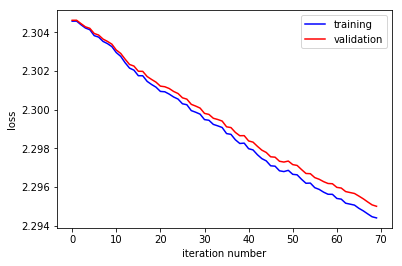

The loss on the  training data is  2.29439873649
The classification error rate on the training data is  0.878
The loss on the  validation data is  2.29500096722
The classification error rate on the validation data is  0.88
The loss on the  test data is  2.29463898534
The classification error rate on the test data is  0.8763333333333333
end


In [ ]:
#Q3 2.294398
a3(0, 10, 70, 0.005, 0, False, 4)

In [ ]:
a3(0, 10, 70, 0.005, 0, False, 4)

Error! Theta element # 1642 , with value  0.046369533543 has finite difference gradient -0.00269888772205 but analytic gradient is -0.0269754389338 That looks like an error.
Error! Theta element # 623 , with value  0.0999375415997 has finite difference gradient -0.000629245939724 but analytic gradient is -0.00629429336853 That looks like an error.
Error! Theta element # 2264 , with value  0.0494715045845 has finite difference gradient 0.00129069669896 but analytic gradient is 0.0128815619546 That looks like an error.
Error! Theta element # 1245 , with value  0.0997502444198 has finite difference gradient -0.0009895107284 but analytic gradient is -0.0099055707942 That looks like an error.
Error! Theta element # 226 , with value  0.036731936773 has finite difference gradient -0.000833860505686 but analytic gradient is -0.00832806879328 That looks like an error.
Error! Theta element # 1867 , with value  0.0994383424259 has finite difference gradient -0.000761337552256 but analytic gradien

momentums [0.0, 0.9] lr 0.002


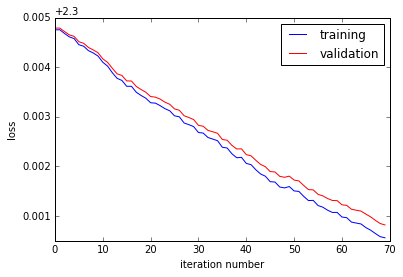

The loss on the  training data is  2.30056052104
The classification error rate on the training data is  0.879
The loss on the  validation data is  2.30082007077
The classification error rate on the validation data is  0.881
The loss on the  test data is  2.30069185263
The classification error rate on the test data is  0.8805555555555555
momentums [0.0, 0.9] lr 0.01


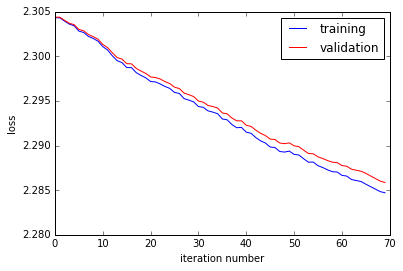

The loss on the  training data is  2.2847075625
The classification error rate on the training data is  0.859
The loss on the  validation data is  2.28585975529
The classification error rate on the validation data is  0.863
The loss on the  test data is  2.28512407282
The classification error rate on the test data is  0.8544444444444445
momentums [0.0, 0.9] lr 0.05


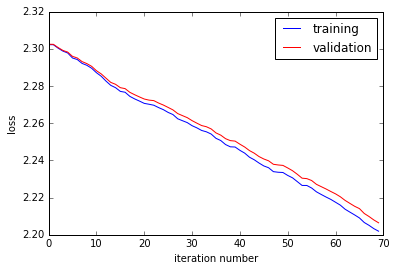

The loss on the  training data is  2.20193091775
The classification error rate on the training data is  0.648
The loss on the  validation data is  2.20644445762
The classification error rate on the validation data is  0.658
The loss on the  test data is  2.20309511468
The classification error rate on the test data is  0.662
momentums [0.0, 0.9] lr 0.2


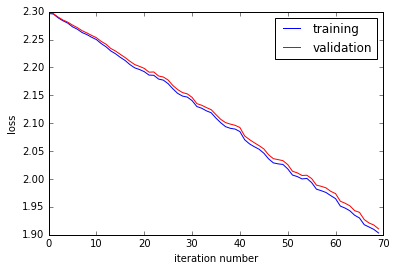

The loss on the  training data is  1.90325345453
The classification error rate on the training data is  0.63
The loss on the  validation data is  1.91058344638
The classification error rate on the validation data is  0.642
The loss on the  test data is  1.90415668612
The classification error rate on the test data is  0.6324444444444445
momentums [0.0, 0.9] lr 1.0


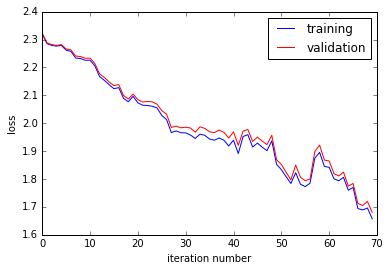

The loss on the  training data is  1.65752759608
The classification error rate on the training data is  0.636
The loss on the  validation data is  1.68027272433
The classification error rate on the validation data is  0.653
The loss on the  test data is  1.66925877347
The classification error rate on the test data is  0.6356666666666667
momentums [0.0, 0.9] lr 5.0


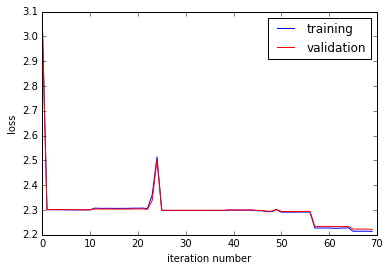

The loss on the  training data is  2.2137415418
The classification error rate on the training data is  0.883
The loss on the  validation data is  2.22155197436
The classification error rate on the validation data is  0.871
The loss on the  test data is  2.2259457028
The classification error rate on the test data is  0.8797777777777778
momentums [0.0, 0.9] lr 20.0


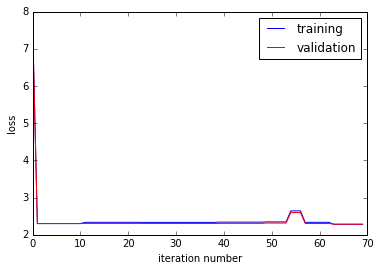

The loss on the  training data is  2.28232395436
The classification error rate on the training data is  0.917
The loss on the  validation data is  2.28464480499
The classification error rate on the validation data is  0.919
The loss on the  test data is  2.28001871107
The classification error rate on the test data is  0.905
momentums [0.0, 0.9] lr 0.002


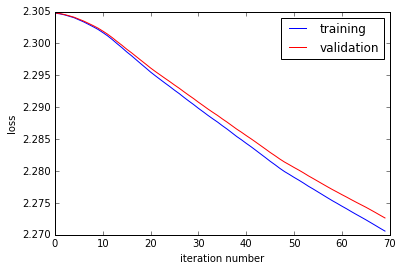

The loss on the  training data is  2.27058193988
The classification error rate on the training data is  0.735
The loss on the  validation data is  2.27264012082
The classification error rate on the validation data is  0.744
The loss on the  test data is  2.27121982349
The classification error rate on the test data is  0.7375555555555555
momentums [0.0, 0.9] lr 0.01


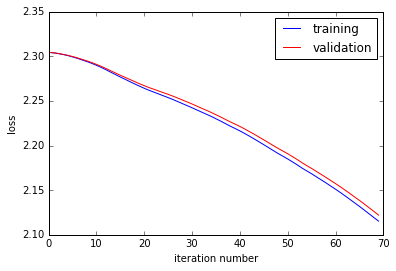

The loss on the  training data is  2.1152701199
The classification error rate on the training data is  0.703
The loss on the  validation data is  2.1220524923
The classification error rate on the validation data is  0.71
The loss on the  test data is  2.1158897218
The classification error rate on the test data is  0.6923333333333334
momentums [0.0, 0.9] lr 0.05


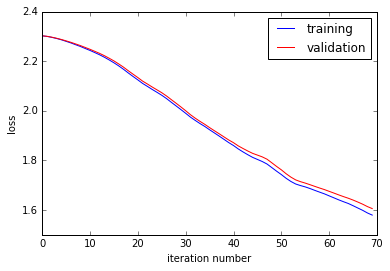

The loss on the  training data is  1.57945390322
The classification error rate on the training data is  0.541
The loss on the  validation data is  1.60574321521
The classification error rate on the validation data is  0.561
The loss on the  test data is  1.58964575906
The classification error rate on the test data is  0.5598888888888889
momentums [0.0, 0.9] lr 0.2


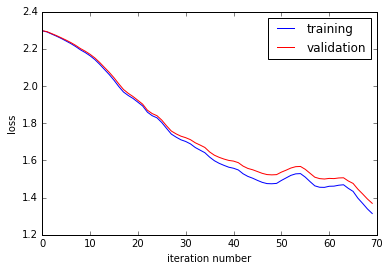

The loss on the  training data is  1.31440905102
The classification error rate on the training data is  0.447
The loss on the  validation data is  1.36917184572
The classification error rate on the validation data is  0.482
The loss on the  test data is  1.35389733529
The classification error rate on the test data is  0.4618888888888889
momentums [0.0, 0.9] lr 1.0


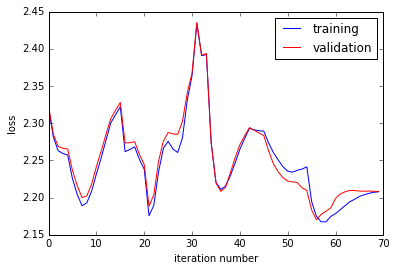

The loss on the  training data is  2.20789618204
The classification error rate on the training data is  0.817
The loss on the  validation data is  2.20804089777
The classification error rate on the validation data is  0.83
The loss on the  test data is  2.21512312557
The classification error rate on the test data is  0.826
momentums [0.0, 0.9] lr 5.0


C:\Users\Wisp\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
C:\Users\Wisp\Anaconda3\lib\site-packages\ipykernel\__main__.py:31: RuntimeWarning: overflow encountered in exp


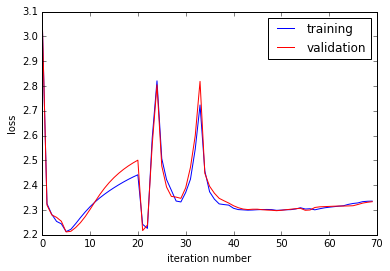

The loss on the  training data is  2.33581199104
The classification error rate on the training data is  0.873
The loss on the  validation data is  2.33348444999
The classification error rate on the validation data is  0.879
The loss on the  test data is  2.33159599067
The classification error rate on the test data is  0.874
momentums [0.0, 0.9] lr 20.0


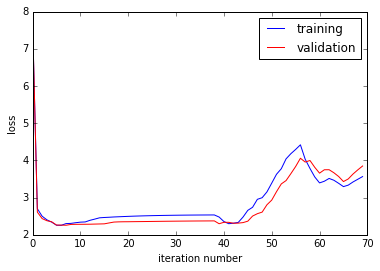

The loss on the  training data is  3.5650991493
The classification error rate on the training data is  0.833
The loss on the  validation data is  3.84952472982
The classification error rate on the validation data is  0.848
The loss on the  test data is  3.73291563178
The classification error rate on the test data is  0.8381111111111111


In [ ]:
learning_rates = [0.002, 0.01, 0.05, 0.2, 1.0, 5.0, 20.0]
momentums = [0.0,0.9]
for momentum in momentums:
    for lr in learning_rates:
        print("momentum",momentum,"lr",lr)
        a3(0, 10, 70, lr, momentum, False, 4)

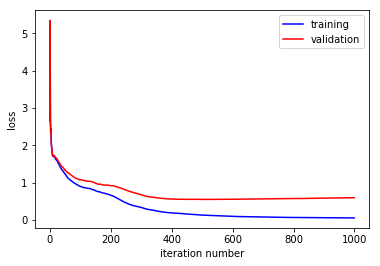

The loss on the  training data is  0.0513035047951
The classification error rate on the training data is  0.013
The loss on the  validation data is  0.592698753603
The classification error rate on the validation data is  0.107
The loss on the  test data is  0.632910204563
The classification error rate on the test data is  0.11355555555555556
end


In [4]:
#q6 0.592698
a3(0, 200, 1000, 0.35, 0.9, False, 100)

Early stopping: validation loss was lowest after  507 iterations. We chose the model that we had then.


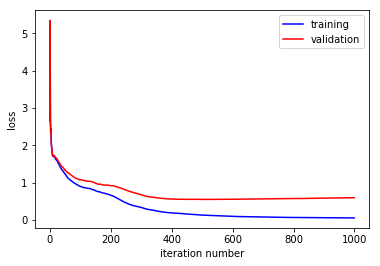

The loss on the  training data is  0.124530410097
The classification error rate on the training data is  0.03
The loss on the  validation data is  0.54726000317
The classification error rate on the validation data is  0.12
The loss on the  test data is  0.582026164368
The classification error rate on the test data is  0.12266666666666666
end


In [5]:
#Q7 0.547260\
a3(0, 200, 1000, 0.35, 0.9, True, 100)

0.0001


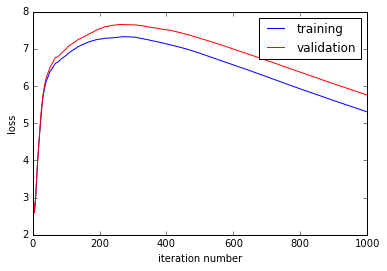

The loss on the  training data is  5.30544831703
The classification loss (i.e. without weight decay) on the  training data is  0.033807455085
The classification error rate on the training data is  0.007
The loss on the  validation data is  5.7572928827
The classification loss (i.e. without weight decay) on the  validation data is  0.485652020757
The classification error rate on the validation data is  0.089
The loss on the  test data is  5.80762802358
The classification loss (i.e. without weight decay) on the  test data is  0.535987161629
The classification error rate on the test data is  0.10622222222222222
end
0.001


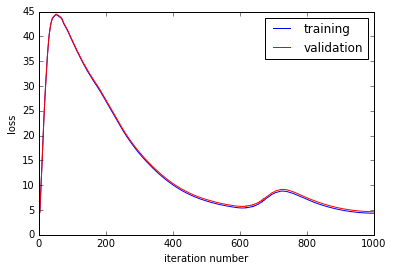

The loss on the  training data is  4.34518199031
The classification loss (i.e. without weight decay) on the  training data is  0.0169051073495
The classification error rate on the training data is  0.0
The loss on the  validation data is  4.65693732854
The classification loss (i.e. without weight decay) on the  validation data is  0.328660445582
The classification error rate on the validation data is  0.091
The loss on the  test data is  4.6530625963
The classification loss (i.e. without weight decay) on the  test data is  0.324785713344
The classification error rate on the test data is  0.08822222222222222
end
0.01


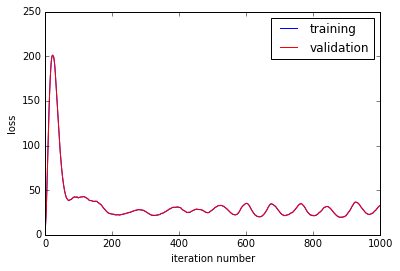

The loss on the  training data is  32.5108616965
The classification loss (i.e. without weight decay) on the  training data is  0.46521776099
The classification error rate on the training data is  0.128
The loss on the  validation data is  32.7244601483
The classification loss (i.e. without weight decay) on the  validation data is  0.678816212808
The classification error rate on the validation data is  0.193
The loss on the  test data is  32.6854592285
The classification loss (i.e. without weight decay) on the  test data is  0.639815292989
The classification error rate on the test data is  0.174
end
1


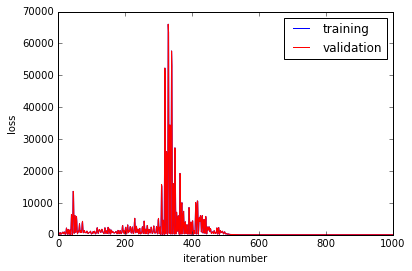

The loss on the  training data is  29.3437184673
The classification loss (i.e. without weight decay) on the  training data is  2.11116168647
The classification error rate on the training data is  0.752
The loss on the  validation data is  29.3468151783
The classification loss (i.e. without weight decay) on the  validation data is  2.11425839754
The classification error rate on the validation data is  0.743
The loss on the  test data is  29.3383499178
The classification loss (i.e. without weight decay) on the  test data is  2.10579313698
The classification error rate on the test data is  0.7428888888888889
end
5


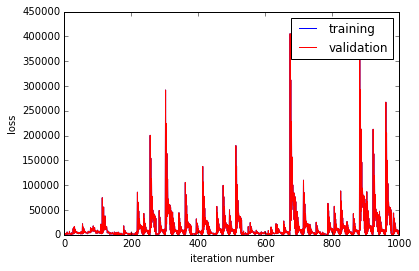

The loss on the  training data is  572.564808039
The classification loss (i.e. without weight decay) on the  training data is  3.23463816007
The classification error rate on the training data is  0.9
The loss on the  validation data is  572.587733423
The classification loss (i.e. without weight decay) on the  validation data is  3.25756354323
The classification error rate on the validation data is  0.9
The loss on the  test data is  572.628781011
The classification loss (i.e. without weight decay) on the  test data is  3.29861113192
The classification error rate on the test data is  0.9
end


In [ ]:
decays = [0.0001,0.001,0.01,1,5]
for decay in decays:
    print(decay)
    a3(decay, 200, 1000, 0.35, 0.9, False, 100)

layer 10


C:\Users\mpavlov\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:148: RuntimeWarning: overflow encountered in exp
C:\Users\mpavlov\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in exp


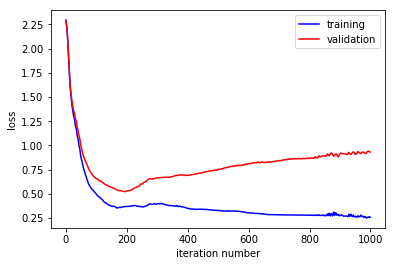

The loss on the  training data is  0.257025851688
The classification error rate on the training data is  0.081
The loss on the  validation data is  0.929113890532
The classification error rate on the validation data is  0.248
The loss on the  test data is  0.829501386988
The classification error rate on the test data is  0.22966666666666666
end
layer 30


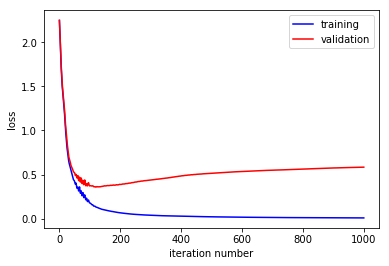

The loss on the  training data is  0.00806064047845
The classification error rate on the training data is  0.0
The loss on the  validation data is  0.583780666
The classification error rate on the validation data is  0.128
The loss on the  test data is  0.559602695763
The classification error rate on the test data is  0.11455555555555555
end
layer 100


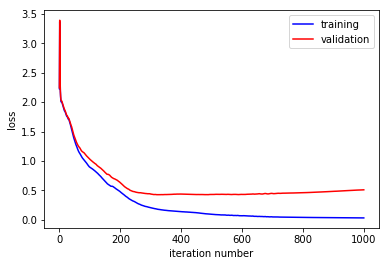

The loss on the  training data is  0.0321190624604
The classification error rate on the training data is  0.007
The loss on the  validation data is  0.50949565418
The classification error rate on the validation data is  0.114
The loss on the  test data is  0.512591743289
The classification error rate on the test data is  0.11166666666666666
end
layer 130


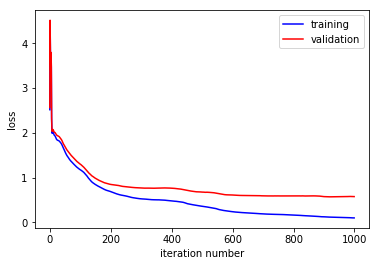

The loss on the  training data is  0.0998365376278
The classification error rate on the training data is  0.028
The loss on the  validation data is  0.576054053715
The classification error rate on the validation data is  0.127
The loss on the  test data is  0.534320688158
The classification error rate on the test data is  0.12766666666666668
end
layer 200


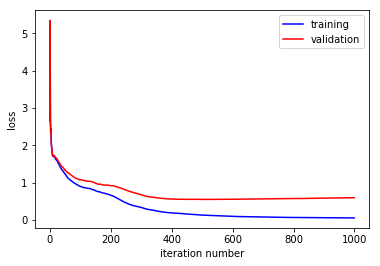

The loss on the  training data is  0.0513035047951
The classification error rate on the training data is  0.013
The loss on the  validation data is  0.592698753603
The classification error rate on the validation data is  0.107
The loss on the  test data is  0.632910204563
The classification error rate on the test data is  0.11355555555555556
end


In [3]:
layers = [10,30,100,130,200]
for layer in layers:
    print("layer",layer)
    a3(0, layer, 1000, 0.35, 0.9, False, 100)

In [ ]:
layers = [18,37,83,113,226]
for layer in layers:
    print("layer",layer)
    a3(0, layer, 1000, 0.35, 0.9, True, 100)